In [1]:
%load_ext autoreload
%autoreload 2
import os
if os.path.basename(os.path.abspath(os.curdir)) == 'notebook':
    os.chdir('../.')

import sys
import torch
import os 
import sys
import pickle
from sketch_gnn.utils import flat_array
from sketch_gnn.dataloader.generate_dataModule import SketchGraphDataModule, generate_dataset
from sketch_gnn.models.gat import GaT
from sketch_gnn.utils.to_dict import parse_config
from sketch_gnn.utils.logger import logger

SAVED_MODEL_PATH= '/home/f49681/data/sg/models/v004/gat-epoch=102-val_loss=0.00.ckpt'
SEQUENCE_DATA= 'data/normalization_output_merged.npy'

# Load config
conf = parse_config('config/gat.yml')
d_train = conf.get('train')
d_train['batch_size'] = 128
with open(conf.get('prep_parms_path'), 'rb') as f:
    d_prep = pickle.load(f)

# Load Model
d_model = conf.get('model')
device = 'cpu'
model = GaT(d_model, d_prep)
model.to(device)
state_dict = torch.load(SAVED_MODEL_PATH, map_location=torch.device('cpu'))['state_dict']
new_state_dict = {}
for k,v in state_dict.items():
    new_key = k[6:] # remove 'model.' from key names
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)
model.train(False)

# Load dataloder 
graph_datamodule = SketchGraphDataModule(conf, d_prep)
dataloader = graph_datamodule.val_dataloader()
batch_iterator = iter(dataloader)

# Load sequence dataset for visualization
sequence_data = flat_array.load_flat_array(SEQUENCE_DATA)

EDGE_IDX_MAP = d_prep.get('edge_idx_map')
NODE_IDX_MAP = d_prep.get('node_idx_map')




INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpaayihopw
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpaayihopw/_remote_module_non_sriptable.py
INFO:root:-- Load Validation Set
DEBUG:root:Load datasets...
DEBUG:root:Load weights


## Positional Encoding

In [2]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
def plot_pca(data, n_components = 3):
    pca = PCA(n_components=n_components)
    pca_output = pca.fit_transform(data)
    plt.plot(pca_output)
    ratios = pca.explained_variance_ratio_
    legend = [f'component {n}, variance ratio:{int(r*100)}%' for n,r in enumerate(ratios)]
    plt.legend(legend)
    plt.tight_layout()

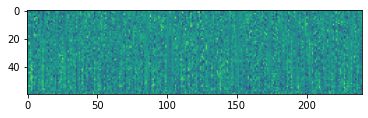

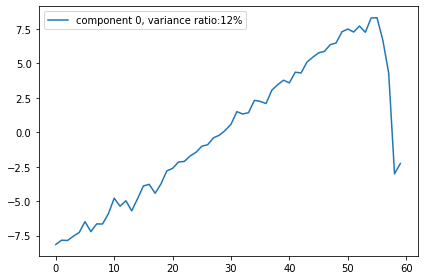

In [3]:
model.to('cpu')
with torch.no_grad():
    pos_output = model.positional_encoding(torch.arange(60))
plt.imshow(pos_output)
plt.show()
plot_pca(pos_output, n_components=1)

# Embedding Parameters

### Angles
angles follow sine pattern

### x,y coordinates
No real interpretation

### Radius
Strange

In [8]:
# primitive = 'ARC'
primitive = 'POINT'
# primitive = 'CIRCLE'

node_feat_dims = d_prep['node_feature_dimensions'][primitive]
print(node_feat_dims)
numFeatEnc = model.node_embedding.feature_embeddings[primitive][0]
weight = numFeatEnc.embeddings.weight.to('cpu').detach()
offset = 0
d_embed_params = {}
for k,v in node_feat_dims.items():
    d_embed_params[k] = weight[offset:offset+v]
    offset+=v


x = d_embed_params['x']
y = d_embed_params['y']
print(x.shape)
pca = PCA(n_components=1)
pca_output_x = pca.fit_transform(x)
pca = PCA(n_components=1)
pca_output_y = pca.fit_transform(y)
    

{'status_construction': 2, 'x': 50, 'y': 50}
torch.Size([50, 240])


{'status_construction': 2, 'radius': 50, 'angle_start': 50, 'angle_end': 50}


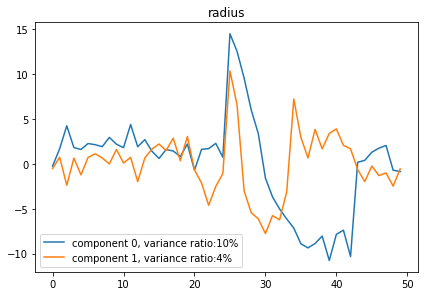

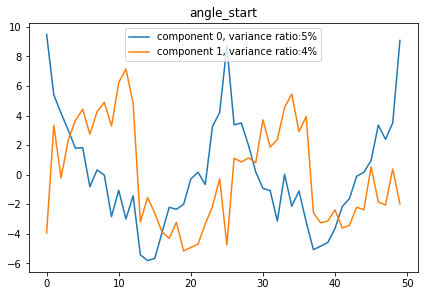

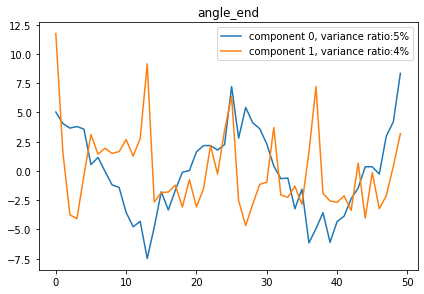

In [6]:
primitive = 'ARC'
# primitive = 'POINT'
# primitive = 'CIRCLE'

node_feat_dims = d_prep['node_feature_dimensions'][primitive]
print(node_feat_dims)
numFeatEnc = model.node_embedding.feature_embeddings[primitive][0]
weight = numFeatEnc.embeddings.weight.to('cpu').detach()
offset = 0
d_embed_params = {}
for k,v in node_feat_dims.items():
    d_embed_params[k] = weight[offset:offset+v]
    offset+=v

for key in list(d_embed_params.keys())[1:]:
    plt.figure()
    data = d_embed_params[key]
    plot_pca(data, n_components = 2)
    plt.title(key)

{'angle': 50}


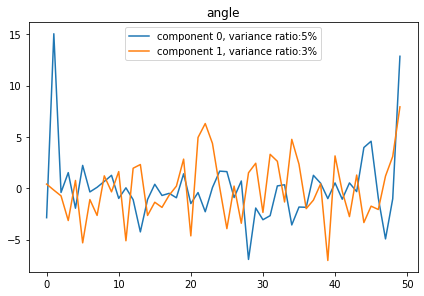

In [10]:
constraint = 'LENGTH'
constraint = 'RADIUS'
constraint = 'ANGLE'

edge_feat_dims = d_prep['edge_feature_dimensions'][constraint]
print(edge_feat_dims)
numFeatEnc = model.edge_embedding.feature_embeddings[constraint][0]
weight = numFeatEnc.embeddings.weight.to('cpu').detach()
offset = 0
d_embed_params = {}
for k,v in edge_feat_dims.items():
    d_embed_params[k] = weight[offset:offset+v]
    offset+=v

for key in list(d_embed_params.keys()):
    plt.figure()
    data = d_embed_params[key]
    plot_pca(data, n_components = 2)
    plt.title(key)

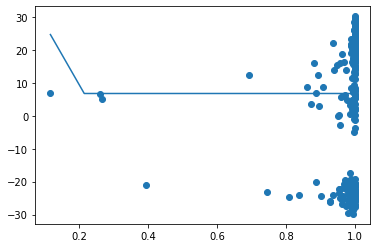

In [62]:
from sketch_gnn.inference.eval import EvalPrediction
import numpy as np
batch = next(batch_iterator)
output = model(batch)
embeddings = model.embeddings(batch_data=batch)
keys = [
    'nodes_bf_msg_passing',
    'edges_bf_msg_passing',
    'nodes_after_msg_passing',
    'nodes_after_transformer',
    'edges_pos_after_transformer',
    'edges_neg_after_transformer',
    'inferred_edges_pos_type',
]
pred = EvalPrediction(batch, output, EDGE_IDX_MAP)
l = len(output['edges_pos'])
scores_pos = pred.predicted_sigmoid[:l]
index = np.argsort(-scores_pos)
edges_after_transformer = embeddings['edges_pos_after_transformer']
edges_pos_sorted = edges_after_transformer[index]
pca = PCA(n_components=1)
pca_output = pca.fit_transform(edges_pos_sorted)
# plot_pca(edges_pos_sorted,n_components=1)
xp = pred.predicted_sigmoid[index]
fp = pca_output.flatten()
x = np.linspace(xp.min(), xp.max(), 10)
interp = np.interp(x=x,xp=xp,fp=fp)
plt.plot(x,interp)
plt.scatter(xp,fp)